<a href="https://colab.research.google.com/github/PaulToronto/Math-and-Data-Science-Reference/blob/main/Interactive_Plotting_in_Matplotlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Plotting in Matplotlib

In [1]:
!pip install -q ipympl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from google.colab import output
output.enable_custom_widget_manager()

%matplotlib widget

## Event Handling

[For more details](https://matplotlib.org/stable/users/explain/event_handling.html)

## Event connections

To receive events:

1. Write a callback function
2. Connect your function to the event manager, which is part of the `FigureCanvasBase`

`mpl_connect` returns a connection id (an integer), which can be used to disconnect the callback via `fig.canvas.mpl_disconnect(cid)`

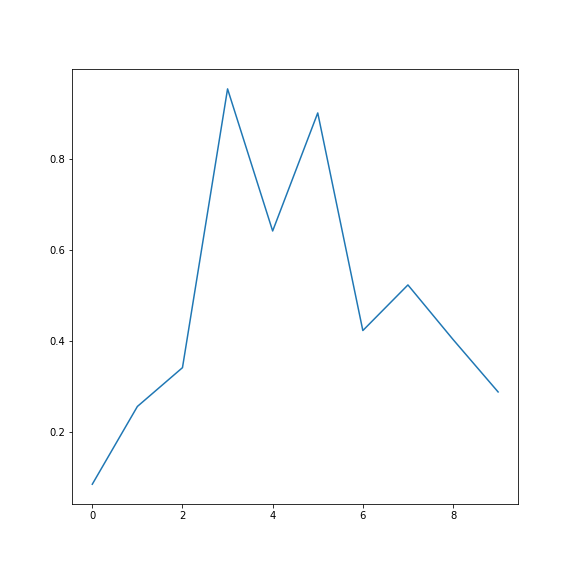

In [3]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(np.random.rand(10))

def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single',
           event.button,
           event.x, 
           event.y,
           event.xdata if event.xdata else -1,
           event.ydata if event.ydata else -1))
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

## List of Events

- 'Event name': `Class`: description
---

- 'button_press_event': `MouseEvent`: mouse button is pressed
- 'button_release_event': `MouseEvent`: mouse button is released
- 'close_event': `CloseEvent`: figure is closed
- 'draw_event': `DrawEvent`: canvas has been drawn (but screen widget not updated yet)
- 'key_press_event': `KeyEvent`: key is pressed
- 'key_release_event': `KeyEvent`: key is released
- 'motion_notify_event': `MouseEvent`: mouse moves
- 'pick_event': `PickEvent`: artist in the canvas is selected
- 'resize_event': `ResizeEvent`: figure canvas is resized
- 'scroll_event': `MouseEvent`: mouse scroll wheel is rolled
- 'figure_enter_event': `LocationEvent`: mouse enters a new figure
- 'figure_leave_event': `LocationEvent`: mouse leaves a figure
- 'axes_enter_event': `LocationEvent`: mouse enters a new axes
- 'axes_leave_event': `LocationEvent`: mouse leaves an axes

## Event attributes

- All `matplotlib` events inherit from the base class `matplotlib.backend_bases.Event`
- as such they have these attributrs
    1. `name`: the event name
    2. `canvas`: the `FigureCanvas` instance generating the event
    3. `guiEvent`: the GUI event that triggered the `matplotlib` event

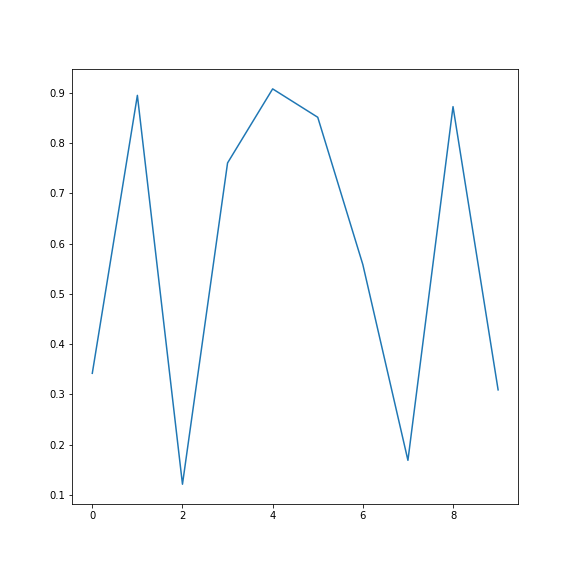

In [4]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(np.random.rand(10))

def onclick(event):
    print(event.name)
    print(type(event.name))
    print('\n--')
    print(event.canvas, type(event.canvas))
    print(type(event.canvas))
    print('\n--')
    print(event.guiEvent)
    print(type(event.guiEvent))
    print('\n--')
    print(event.inaxes)

cid2 = fig.canvas.mpl_connect('button_press_event', onclick)

## Most Common Events

1. `KeyEvent`
    - key_press_event
    - key_release_event
2. `MouseEvent`
    - button_press_event
    - button_release_event
    - motion_notify_event
    - scroll_event

Both of these events are derived from the `LocationEvent` which has the following attributes:

- `x`: mouse x position in pixels from (left, bottom)
- `y`: mouse y position in pixels from (left, bottom)
- `inaxes`: the `Axes` instance over which the mouse is, if any, else `None`
- `xdata`: mouse x position in data coordinates if the mouse is over an axes
- `ydata`: mouse x position in data coordinates if the mouse is over an axes

## Example

- In this canvas, a simple line segment is created every time a mouse is pressed

In [5]:
# this technique is used below
#  to get the element from the list 
#  instead of the list itself
test, = [0]
test

0

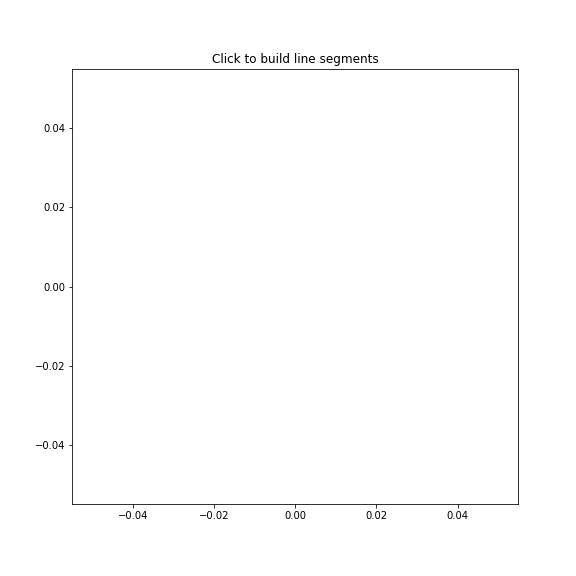

In [6]:
class LineBuilder:
    def __init__(self, line):
        self.line = line
        self.xs = list(line.get_xdata())
        self.ys = list(line.get_ydata())
        self.cid = line.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        #print('click', event)
        if event.inaxes != self.line.axes:
            return 
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.line.set_data(self.xs, self.ys)
        self.line.figure.canvas.draw()

        # in addition to those Location event attributes,
        #   the MouseEvent also has access to the button attribute
        #   and key attribute
        print(event.button, event.key)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title('Click to build line segments')
line, = ax.plot([0], [0])
linebuilder = LineBuilder(line)

## Draggable Rectangle Exercise

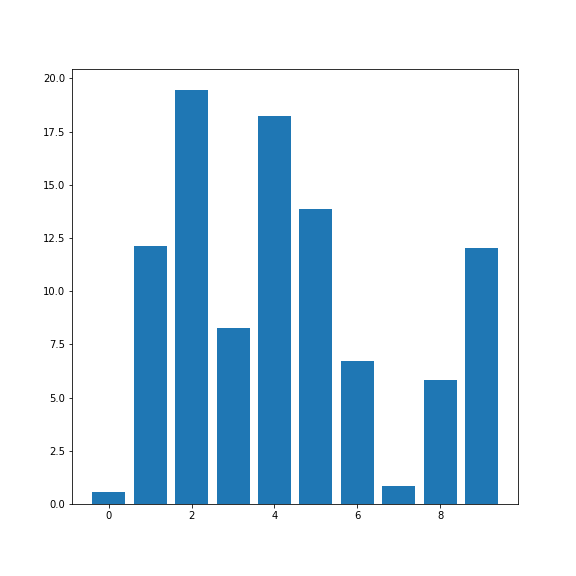

In [7]:
class DraggableRectangle:
    def __init__(self, rect):
        self.rect = rect
        self.press = None

    def connect(self):
        """Connect to all events we need"""
        self.cidpress = self.rect.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.rect.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)
        self.cidmotion = self.rect.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)

    def on_press(self, event):
        if event.inaxes != self.rect.axes:
            return
        contains, attrd = self.rect.contains(event)
        if not contains:
            return
        #print('event contains', self.rect.xy)
        self.press = self.rect.xy, (event.xdata, event.ydata)
        #print(self.press)

    def on_motion(self, event): 
        """Move the rectangle if the mouse is over us"""
        if self.press is None or event.inaxes != self.rect.axes:
            return 
        (x0, y0), (xpress, ypress) = self.press 
        dx = event.xdata - xpress 
        dy = event.ydata - ypress
        self.rect.set_x(x0 + dx)
        self.rect.set_y(y0 + dy)
        self.rect.figure.canvas.draw()

    def on_release(self, event): 
        """Clear button press information"""
        self.press = None 
        self.rect.figure.canvas.draw()

    def disconnect(self):
        """Disconnect all callbacks."""
        self.rect.figure.canvas.mpl_disconnect(self.cidpress)
        self.rect.figure.canvas.mpl_disconnect(self.cidrelease)
        self.rect.figure.canvas.mpl_disconnect(self.cidmotion)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
rects = ax.bar(range(10), 20 * np.random.rand(10))

# Reason for `drs` variable
# The canvas retains only weak references to instance 
# methods used as callbacks. Therefore, you need to 
# retain a reference to instances owning such methods. 
# Otherwise the instance will be garbage-collected 
# and the callback will vanish.
# This does not affect free functions used as callbacks.
drs = []
for rect in rects:
    dr = DraggableRectangle(rect)
    dr.connect()
    drs.append(dr)

plt.show()

## Mouse enter and leave

- If you want to be notified when the mouse enters or leaves a figure or axes
    - connect to the figure/axes enter/leave events

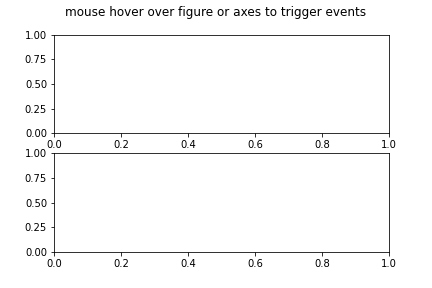

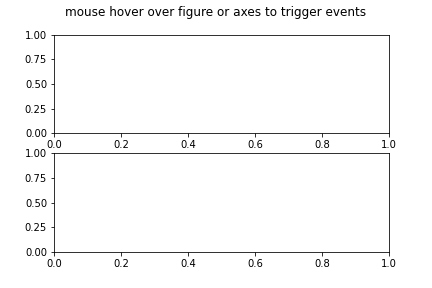

In [8]:
"""
Illustrate the figure and axes enter and leave events by changing the
frame colors on enter and leave
"""

def enter_axes(event):
    print('enter_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('yellow')
    event.canvas.draw()

def leave_axes(event):
    print('eave_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('white')
    event.canvas.draw()

def enter_figure(event):
    print('enter_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('red')
    event.canvas.draw()

def leave_figure(event):
    print('leave_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('grey')
    event.canvas.draw()



fig1, axs = plt.subplots(2)
fig1.suptitle("mouse hover over figure or axes to trigger events")

fig1.canvas.mpl_connect('figure_enter_event', enter_figure)
fig1.canvas.mpl_connect('figure_leave_event', leave_figure)
fig1.canvas.mpl_connect('axes_enter_event', enter_axes)
fig1.canvas.mpl_connect('axes_leave_event', leave_axes)

fig2, axs = plt.subplots(2)
fig2.suptitle("mouse hover over figure or axes to trigger events")

fig2.canvas.mpl_connect('figure_enter_event', enter_figure)
fig2.canvas.mpl_connect('figure_leave_event', leave_figure)
fig2.canvas.mpl_connect('axes_enter_event', enter_axes)
fig2.canvas.mpl_connect('axes_leave_event', leave_axes)

plt.show()

## Object picking

- enable picking by setting the `picker` property of an `Artist`
    - `class matplotlib.artist.Artist`: abstract base class for objects that render into a `FigureCanvas`
    - basically, all visible elements in a figure are subclasses of `Artist`
- the `picker` property can be set using various types:
    1. `None`: picking is disabled for this artist (default)
    2. `boolean`: if `True` then picking is enabled for this artist and the artist will fire a pick evetn of the mouse event is over the artist
    3. `callable`: if picker is a callable, it is a user supplied function which dtermins whether the arist is hit by the mouse event. 
        - the signature: `hit, props = picker(artist, mouseevent)`
        - if the mouse event is over the artist, return `hit = True`
        - `props` is a dictionary of properties that become additional attribues on the `PickEvent`
- after enabling an artist for picking by setting `picker=True`, you need to connect a handler to the figure canvas pick_event to get pick callbacks on mouse press events. The handler typically looks like this:

In [9]:
def pick_handler(event):
    mousevent = event.MouseEvent
    artist = event.artist 
    # now do something with this

- the `PickEvent` passed to your callback always has the following attribues:
    - `mouseevent`: the `MouseEvent` that generates the pick event
    - `artist`: the `Artist`that generated the pick event

((0.0, 0.310757801673916), (1.0, 0.7437824489631241), (2.0, 0.49008250600098036), (3.0, 0.79640774563851), (4.0, 0.7893043822148781), (5.0, 0.7183932703703972), (6.0, 0.056188483511901643), (7.0, 0.7162422571147763), (8.0, 0.832177414751598), (9.0, 0.8104090959985071), (10.0, 0.49999643846014474), (11.0, 0.20445210358399812), (12.0, 0.5395573894944468), (13.0, 0.4036031910129657), (14.0, 0.4715371429989649), (15.0, 0.8780059729055282), (16.0, 0.32738658622419214), (17.0, 0.34660802476209696), (18.0, 0.19788690489447502), (19.0, 0.1332292913064732), (20.0, 0.2994054064535979), (21.0, 0.11017992604671045), (22.0, 0.08706878546157337), (23.0, 0.0627832452656909), (24.0, 0.0404749805186142), (25.0, 0.6946279612221776), (26.0, 0.5418693258856507), (27.0, 0.932441822649669), (28.0, 0.4210822208653239), (29.0, 0.14741221479086553), (30.0, 0.5308002598840234), (31.0, 0.12644731382532381), (32.0, 0.8261996982363246), (33.0, 0.29262204075574694), (34.0, 0.046082463774083315), (35.0, 0.5080703939

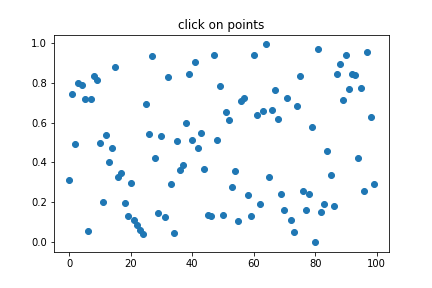

In [10]:
fig, ax = plt.subplots()
ax.set_title('click on points')

line, = ax.plot(np.random.rand(100), 'o', picker=True, pickradius=5)
print(tuple(zip(line.get_xdata(), line.get_ydata())))

def onpick(event):
    thisline = event.artist
    xdata = thisline.get_xdata()
    ydata = thisline.get_ydata()
    ind = event.ind
    print(ind)
    points = tuple(zip(xdata[ind], ydata[ind]))
    print('onpick points:', points)

fig.canvas.mpl_connect('pick_event', onpick)

plt.show()